<a href="https://colab.research.google.com/github/Vmjkom/Deep-learning-nlp/blob/master/Ryhm%C3%A4_3_Textual_Data_Analysis_group_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ryhmän jäsenet: Nimi, opnro

Ville Komulainen, 519246 (Lead contributions on milestone 3 and parts of milestone 2, supporting role in the rest)

Hanna Kitti, 523087 (Lead contributions on milestone 2, supporting role on other milestones)

Kukka Vainio, 520261 (Supportive role on all the milestones, contributed thoughts in text form about the data and used methods)

Saara Kaltiomaa, 519209 (Supportive role on all the milestones, contributed to the analysis of the test performance and the outputs.)



# Instructions

In this notebook implement a machine learning-based information extraction system that identifies binary relations stated to hold between specific named entities mentioned in the same sentence (e.g. PERSON founded ORGANIZATION). 

The projects is divided into three milestones:

 * Milestone 1: Manual relation annotation using texts and tool 
provided by course organizers.

 * Milestone 2: Implementation of machine-learning based method for relation extraction. 

 * Milestone 3: Large-scale application, assessment and and error analysis of method implemented in milestone 2.

Each group is expected to prepare a report on their work. Reports can be in any broadly supported format (e.g. PDF or Python notebook) and should include both the code implementing the project (separate .py files are OK) as well as a textual description of the project and its results.

The contribution of each member of the group should be varied across all the facets of the project, and the project report should include a statement on what the contribution of each member towards each milestone was.

Additional guidance from Discord:

"For milestone 2, the minimum for "completing" will be outperforming the majority baseline, which will hopefully not be particularly challenging. For the additional point, going the extra mile in terms like considering multiple metrics, models, or **input representations** and/or doing hyperparameter optimization count. For milestone 3, the minimum for "complete" is successfully applying the model to a larger set of new data and **reporting some meaningful descriptive metrics about the result, and for the extra point e.g. error analysis or comparing different model variants will suffice**. Basically, if you've successfully completed all milestones, can show effort beyond the minimum at each, and have written up your work in a reasonable way, you can expect to receive full points"

### Relation extraction system task formulation

This description of ML task formulation is from UTU Textual Data analysis [course material](https://colab.research.google.com/github/TurkuNLP/Text_Mining_Course/blob/master/Relation%20extraction.ipynb#scrollTo=PKjG5UlObCZs)

Given manually annotated examples where each consists of

* Document text $d$
* Two entity mentions in that document, $m_1$ and $m_2$
* Relation type (e.g. `employee`) or `NONE` to signify no relation

relation extraction can be formulated as a classification task by creating an representation of the mentions $m_1$ and $m_2$ in their context ($d$) as input and the relation type (or `NONE`) as output. (Note that this assumes at most one relation type holds per entity pair.)

In previous state-of-the-art approaches, considerable effort was invested into creating representations of the mentions in context for ML methods, frequently involving e.g. carefully engineered representations of dependency paths.

Fortunately for us, with recent Transformer-based approaches such as BERT, these representations can be simplified into marking the entities in the original text in some way, and providing the text with marked entities to the model as input.

For example, given

* Document text $d$ = `Bill Gates and Paul Allen founded Microsoft`
* Mentions $m_1$ = `(0, 10, PERSON, Bill Gates)` and $m_2$ = `(34, 43, ORG, Microsoft)`
* Relation type `founder`

We could formulate the classification example e.g. as

* input: `PERSON and Paul Allen founded ORGANIZATION`
* output: `founder`

Here using the literal type strings `PERSON` and `ORGANIZATION` to mark the two mentions under consideration. (Note that other mentions in context are not marked.)

(**Project work** As the course project involves implementing a relation extraction system along the lines outlined above, we will not provide an implementation here. You may find the previously covered notebooks on text classification helpful as references for your implementation.)

Machine learning means the "rules" for solving the given task are learned from examples, they are not explicitly written.

##Milestone 1

Initial thoughts during annotation phase:
- A large number of samples that deal with sports topics (being a member of a team, transferring to a team, coaching etc.)  model might do well with sport-related data, but does it get too little practice with other topics?
- Some quite bad and even unsuitable text samples, e.g. long lists of people’s names without any sentence structure or even samples in other languages like German  still not a significant amount and most discarded during the annotation progress
- Relatively often we encountered samples where the named entities were tagged wrong
- We also pondered how consistent the four of us were as annotators. If our annotations are not mutually consistent, the model is trained with contradictory data, which might lead to low quality performance.



# Imports 

In [1]:
!pip --quiet install datasets
!pip --quiet install transformers

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import torch

from datasets import Dataset, DatasetDict, ClassLabel, Value, Features, load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback, TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix

# MS 2: Implementation of machine-learning based method for relation extraction. 

In [3]:
!wget -q -nc http://dl.turkunlp.org/TKO_8964_2021/PER-ORG-relations-combined-group-3.tsv


In [4]:

def open_file(file):
  df = pd.read_csv(file, sep='\t', header=None)
  df = df.rename(columns={0: 'id', 1: 'label', 2: 'document'})
  df = df.drop('id', axis=1)
  return df

data = open_file('PER-ORG-relations-combined-group-3.tsv')


## Explore the data

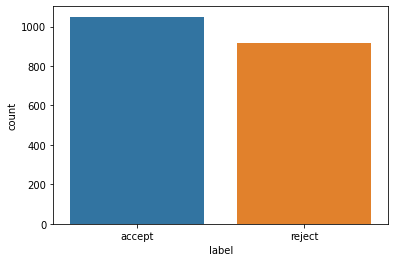

In [5]:
sns.countplot(data=data, x='label');

The data is rather balanced since the sizes of the two classes seem to be equal. This is a good starting point for training the model.

In [6]:
# We have these classes in the data
set(data['label'])

{'accept', 'reject'}

In [7]:
# print a sample of the data

for i in range(0,2000,300):
  print(data['label'][i], '\t', data['document'][i])
  print()

accept 	 Vuonna 2003 <PERSON>di Grassi</PERSON> ajoi Etelä - Amerikan F3 - sarjaa , jossa hän oli sarjan kakkonen ja samana vuonna hän ajoi myös Formula 3 Eurosarjaa , jossa hän oli loppupisteissä 21 . Vuonna 2004 di Grassi ajoi Britannian <ORG>F3</ORG> - sarjaa , jossa hän sijoittui loppupisteissä kahdeksanneksi .

accept 	 <ORG>HePoa</ORG> oli edustamassa varapuheenjohtaja <PERSON>Marjut Ollitervo</PERSON> .

accept 	 <ORG>Arkansasin hallinnon</ORG> työntekijä <PERSON>Paula Jones</PERSON> syytti vuonna 1994 Clintonia vuonna 1991 hotellihuoneessa tapahtuneesta ahdistelusta .

accept 	 Ihan mielenkiinnosta kysyn , että mikä on <PERSON>Keijo Säilynojan</PERSON> rooli <ORG>Jokerien</ORG> toimitusjohtajana ?

reject 	 <ORG>NHL : n</ORG> tähdistöottelussa <PERSON>Belfour</PERSON> pelasi viisi kertaa , vuosina 1992 , 1993 , 1996 , 1998 ja 1999 .

accept 	 Siirtyminen politiikkaan <PERSON>Johnson</PERSON> toimi opettajana <ORG>Houston High Schoolissa</ORG> .

accept 	 ( <ORG>TS : n</ORG> edu

In the input data "documents" we can see the tags signaling named entities:


*   `<ORG> ORGANIZATION </ORG>`
*   `<PERSON> PERSON </PERSON>`

These NER (Named Entity Recognition) tags are used in language modeling to recognize permanent entities and relations between them. 

##Preprocessing the data

### Approach 1

In [8]:
pattern_person = r"<PERSON>.+</PERSON>" # .+ Matches one or more any charachter
docs = [re.sub(pattern_person, "PERSON", item) for item in data['document']]

pattern_org = r"<ORG>.+</ORG>" # .+ Matches one or more any charachter
docs = [re.sub(pattern_org, "ORG", item) for item in docs]

# look at the data now. Is it ok?
for i in range(0,2000,300):
  print("Original:", data['document'][i])
  print("Modified:", docs[i])
  print()

Original: Vuonna 2003 <PERSON>di Grassi</PERSON> ajoi Etelä - Amerikan F3 - sarjaa , jossa hän oli sarjan kakkonen ja samana vuonna hän ajoi myös Formula 3 Eurosarjaa , jossa hän oli loppupisteissä 21 . Vuonna 2004 di Grassi ajoi Britannian <ORG>F3</ORG> - sarjaa , jossa hän sijoittui loppupisteissä kahdeksanneksi .
Modified: Vuonna 2003 PERSON ajoi Etelä - Amerikan F3 - sarjaa , jossa hän oli sarjan kakkonen ja samana vuonna hän ajoi myös Formula 3 Eurosarjaa , jossa hän oli loppupisteissä 21 . Vuonna 2004 di Grassi ajoi Britannian ORG - sarjaa , jossa hän sijoittui loppupisteissä kahdeksanneksi .

Original: <ORG>HePoa</ORG> oli edustamassa varapuheenjohtaja <PERSON>Marjut Ollitervo</PERSON> .
Modified: ORG oli edustamassa varapuheenjohtaja PERSON .

Original: <ORG>Arkansasin hallinnon</ORG> työntekijä <PERSON>Paula Jones</PERSON> syytti vuonna 1994 Clintonia vuonna 1991 hotellihuoneessa tapahtuneesta ahdistelusta .
Modified: ORG työntekijä PERSON syytti vuonna 1994 Clintonia vuonna 1

### Approach 2

We also briefly inspected the option of tagging the entities with BIO-tags (begin, in, out). However we discarded this approach before the model training phase.

In [9]:
one = data['document'][4]
print(one)

<PERSON>Masol</PERSON> vastusti <ORG>Ukrainan kommunistisen puolueen</ORG> 28 . kokouksen päätöstä Ukrainan suvereniteetista ja siirtymisestä säänneltyyn markkinatalouteen , sekä vaatimuksia Neuvostoliiton hajauttamisesta uudelleen liittosopimuksella .


In [10]:
org_start=0
org_end=0

per_start=0
per_end=0

tokens=one.split(" ")
tags = ["O"] * len(tokens) # initialize tags: all O at the start
print(tokens)

for i, t in enumerate(tokens):
  if t.startswith("<ORG>"):
    org_start=i # starting index (B) of multitoken ORG tag
    tags[i]="B_ORG" # replace a tag 
    tokens[i]=re.sub(r"<ORG>", "", t) # remove tag from the tokens
  if t.endswith("</ORG>"):
    org_end=i # ending index of multitoken ORG tag
    tokens[i]=re.sub(r"</ORG>", "", t) # remove tag from the tokens
  # all the same but for PER tags instead of ORG tags
  if t.startswith("<PERSON>"):
    per_start=i
    tags[i]="B_PER"
    tokens[i]=re.sub(r"<PERSON>", "", t)
  if t.endswith("</PERSON>"):
    per_end=i
    tokens[i]=re.sub(r"</PERSON>", "", t)

# use the indices collected above to set the in (I) tags
org_indexes=list(range(org_start+1, org_end+1))
if not org_indexes: # if no indices (i.e. token to be tagged is single)
  tokens[org_start]=re.sub(r"<ORG>", "", tokens[org_start]) # just fix the token
else:
  for index in org_indexes:
    tags[index] = "I_ORG"

# all the same but for PER tags instead of ORG tags
per_indexes=list(range(per_start+1, per_end+1))
if not per_indexes: 
  tokens[per_start]=re.sub(r"<PERSON>", "", tokens[per_start])
for index in per_indexes:
    tags[index] = "I_PER"

for tag, token in zip(tags, tokens):
  print(tag, "\t",token)

['<PERSON>Masol</PERSON>', 'vastusti', '<ORG>Ukrainan', 'kommunistisen', 'puolueen</ORG>', '28', '.', 'kokouksen', 'päätöstä', 'Ukrainan', 'suvereniteetista', 'ja', 'siirtymisestä', 'säänneltyyn', 'markkinatalouteen', ',', 'sekä', 'vaatimuksia', 'Neuvostoliiton', 'hajauttamisesta', 'uudelleen', 'liittosopimuksella', '.']
B_PER 	 Masol
O 	 vastusti
B_ORG 	 Ukrainan
I_ORG 	 kommunistisen
I_ORG 	 puolueen
O 	 28
O 	 .
O 	 kokouksen
O 	 päätöstä
O 	 Ukrainan
O 	 suvereniteetista
O 	 ja
O 	 siirtymisestä
O 	 säänneltyyn
O 	 markkinatalouteen
O 	 ,
O 	 sekä
O 	 vaatimuksia
O 	 Neuvostoliiton
O 	 hajauttamisesta
O 	 uudelleen
O 	 liittosopimuksella
O 	 .


## Gather labels and text data

Now we will make a new dataframe from the preprocessed data and the labels. The labels still need to be worked with.

In [11]:
labels = data['label']
df = pd.DataFrame(list(zip(labels, docs)), columns =['label', 'text'])

print(df.head())
print()

# Replace column values with values given in a dictionary. (Convert string to int.)
# Conversion prepares the label data for being converted to ClassLabel...
conversion_dict = dict(zip(['accept', 'reject'], [1, 0])) 
df=df.replace({'label': conversion_dict})
print(df.head())

    label                                               text
0  accept  Vuonna 2003 PERSON ajoi Etelä - Amerikan F3 - ...
1  accept  ORG puheenjohtaja ja valtiovarainministeri PER...
2  accept  PERSON luottamustehtäviin ovat lukeutuneet muu...
3  accept  ORG , jonka puheenjohtaja on 2011 lähtien PERS...
4  reject  PERSON vastusti ORG 28 . kokouksen päätöstä Uk...

   label                                               text
0      1  Vuonna 2003 PERSON ajoi Etelä - Amerikan F3 - ...
1      1  ORG puheenjohtaja ja valtiovarainministeri PER...
2      1  PERSON luottamustehtäviin ovat lukeutuneet muu...
3      1  ORG , jonka puheenjohtaja on 2011 lähtien PERS...
4      0  PERSON vastusti ORG 28 . kokouksen päätöstä Uk...


## Data to DatasetDict and train-dev-test splits


To be sure that the data is in a suitable format for the model we make it a HuggingFace DatasetDict. We used instructions to build a DatasetDict from the [API documentation](https://huggingface.co/docs/datasets/index.html).

Additional help for building the dataset (especially the Features) was searched from the [Huggingface dataset repository](https://github.com/huggingface/datasets/tree/master/datasets) and [HuggingFace documentation](https://huggingface.co/docs/datasets/package_reference/main_classes.html#features).

In [12]:

# make a Dataset container for the data
dataset = Dataset.from_pandas(df, features=Features( # provide the feature classes to make sure you get what you need
    {'text': Value('string'),
     'label': ClassLabel(num_classes=2,names=['accept', 'reject']) # values 0 and 1, label names accept and reject
     
     }
     )
)

for i in range(5):
  print(dataset['label'][i], "\t", dataset['text'][i])
# Yep, looks good! The format has changed but the contents remain.

1 	 Vuonna 2003 PERSON ajoi Etelä - Amerikan F3 - sarjaa , jossa hän oli sarjan kakkonen ja samana vuonna hän ajoi myös Formula 3 Eurosarjaa , jossa hän oli loppupisteissä 21 . Vuonna 2004 di Grassi ajoi Britannian ORG - sarjaa , jossa hän sijoittui loppupisteissä kahdeksanneksi .
1 	 ORG puheenjohtaja ja valtiovarainministeri PERSON on toivonut laajempaa poliittista keskustelua yksinasuvien asemasta ennen seuraavan hallituksen ohjelman muodostamista .
1 	 PERSON luottamustehtäviin ovat lukeutuneet muun muassa Coronaria Hoitoketjun , Lamor Groupin , SSH Communications Securityn ja ORG hallitusten puheenjohtajuudet .
1 	 ORG , jonka puheenjohtaja on 2011 lähtien PERSON .
0 	 PERSON vastusti ORG 28 . kokouksen päätöstä Ukrainan suvereniteetista ja siirtymisestä säänneltyyn markkinatalouteen , sekä vaatimuksia Neuvostoliiton hajauttamisesta uudelleen liittosopimuksella .


Taking a closer look reveals the classes of the features. For classification we do need to have the ClassLabel class.

In [13]:
dataset.features

{'label': ClassLabel(num_classes=2, names=['accept', 'reject'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

Now we can do the train-dev-test-split. Training data teaches the model, development data gives feedback on the go and test data is the final judgement.

In [14]:
# Split the data first in two parts. Note that this method shuffles the data but it does not do stratification.
# Returns a dictionary (datasets.DatsetDict) with two random train and test subsets (train and test Dataset splits).
train_test = dataset.train_test_split(test_size=0.2) # 0.3
# Split the test data again to gain two datasets: one for development and one for testing
test_data = train_test['test'].train_test_split(test_size=0.5) # 0.2

# Store the data in a DatasetDict (so we can use a map function later to tokenize the data)
dataset = DatasetDict({
    'train': train_test['train'],
    'development': test_data['test'],
    'test': test_data['train']})

print(dataset) # check the splits

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1574
    })
    development: Dataset({
        features: ['label', 'text'],
        num_rows: 197
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 197
    })
})


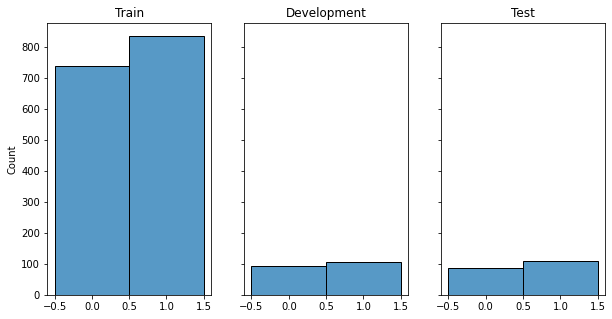

In [15]:
fig, axes  = plt.subplots(1,3, figsize=(10, 5), sharey=True)
fig.suptitle("")
sns.histplot(ax=axes[0], data=dataset['train']['label'], discrete=True)
sns.histplot(ax=axes[1], data=dataset['development']['label'], discrete=True)
sns.histplot(ax=axes[2], data=dataset['test']['label'], discrete=True)

axes[0].set_title("Train")
axes[1].set_title("Development")
axes[2].set_title("Test");

Label distribution in the splits seems to be in balance.

## Import pretrained model and tokenizer

We will first use the [cased multilingual BERT model] from google (https://huggingface.co/bert-base-multilingual-cased) from the Hugging Face model repository.  

Cased model is case sensitive, which means that words starting with capital letters are not the same as words with lower case. For example  "House" is not the same as "house". 


## Set the hyperparameters

In [16]:
MODEL_NAME = 'bert-base-multilingual-cased' 

# Some things to test:
# Learning rate{5e-5, 3e-5, 2e-5}and epochs{2, 3, 4}.Batch size 32 was not used due to memory limitations.

TRAIN_EPOCHS = 5 # at 4 validation loss starts to increase
# How many epochs we train?
# Epoch = the whole data is passed through the model once. Do not train anymore if 
# validation loss is not decreasing or starts increasing. This indicates the model is over fitting.

BATCH_SIZE = 10 # 16 and 32 cause out of memory (OOM) and crash the session
# During an epoch the data is passed through the model in batches (not one by one or all at the 
# same time). The model parameters (weights and bias terms are updated after each batch. This updating is learning.

LEARNING_RATE = 2e-5 # Super important! Try this: 1e-5
# How big or small updates we make to the model after each batch of data




train_args = TrainingArguments(
    'output_dir',
    save_strategy='no',
    evaluation_strategy='epoch', # look at the performence measures (accuracy, precision, recall, F1-score, what ever defined) after each epoch
    logging_strategy='epoch',
    learning_rate=LEARNING_RATE, 
    per_device_train_batch_size=BATCH_SIZE, 
    num_train_epochs=TRAIN_EPOCHS, 
    metric_for_best_model='F1-score', # use with Early Stopping callback
    load_best_model_at_end=True,      # restore the best model when training finishes
    weight_decay=0.01                # strength of weight decay
)

## Load tokenizer and tokenize the data

Tokenizer takes care of preprocessing the data to proper format for the BERT model. The input will be chopped to WordPieces and indices of these tokens form the model input together with the positional encodings. For more information read [HuggingFace documentation](https://huggingface.co/transformers/main_classes/tokenizer.html).


In [17]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) 


Let's explore the tokenizer and the input briefly. Code for exploring was adapted from [stackoverflow](https://stackoverflow.com/questions/63280435/huggingface-transformers-truncation-strategy-in-encode-plus) and UTU Course Deep Learning in Human Language Technology.

In [18]:
toy_seq = "Heippa! Testaan tokenizeria kun mietin, miten paljon tekstiä voikaan laittaa tähän?"

# The length of the input must match the size of the input layer of BERT we are about to use. In our case it is 512.
print(f"Maximum input size of{MODEL_NAME} model: {tokenizer.max_model_input_sizes[MODEL_NAME]}")

# If we do not hit the limit of the model input size when truncation is on, max_length sets the length of the tokenized input. 
max_tokens = 9

tokenized = tokenizer.tokenize(toy_seq, truncation= True, padding = True, max_length = max_tokens) 
input=tokenizer(toy_seq, truncation= True, padding = True, max_length = max_tokens)
print(f"Plain toy input: {toy_seq}")
print(f"Truncated (first {max_tokens}) tokens: {tokenized}")
print(f"Human readable input: {tokenizer.decode(tokenizer(toy_seq, truncation= True, padding = True, max_length = max_tokens)['input_ids'])}") 
# decode the input indices back to text. Compulsory [CLS] and [SEP] tokens are part of the input. They have fixed ids.
print("Model input:")
for key, value in input.items():
  print(key, value)

Maximum input size ofbert-base-multilingual-cased model: 512
Plain toy input: Heippa! Testaan tokenizeria kun mietin, miten paljon tekstiä voikaan laittaa tähän?
Truncated (first 9) tokens: ['He', '##ip', '##pa', '!', 'Test', '##aan', 'tok', '##eni', '##zer']
Human readable input: [CLS] Heippa! Testaan tok [SEP]
Model input:
input_ids [101, 10357, 17437, 11359, 106, 22495, 12521, 18436, 102]
token_type_ids [0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1]


token_type_ids and attention_mask are irrelevant features for our classification task. Since the text sequences are not paired the token_type_ids are all 0 and since we do not pad the input for this task, all of the input is informative and attention mask value is 1 for all of the tokens. See more from [here](https://huggingface.co/transformers/glossary.html#attention-mask) and [here](https://https://huggingface.co/transformers/glossary.html#token-type-ids) in HuggingFace documentation.

Now we will tokenize the real data. By setting truncation = True in the tokenizer parameters we make sure that the tokenizer limits the input size to 512 tokens.

In [19]:
def encode_dataset(d):
  return tokenizer(d['text'], truncation=True) 

encoded_dataset = dataset.map(encode_dataset) #tokenize all of the data with map-method

In [20]:
lens = [len(input) for input in encoded_dataset['train']['input_ids']]
lens.sort(reverse=True)
print(lens[:10]) # longest inputs have length of 512

[512, 512, 512, 512, 480, 451, 447, 412, 405, 389]


## Prepare metrics

Metrics are used to evaluate both the training of the model and the performance of the best model (the combination of the best hyperparameters for the model). 

A plain training process without any metrics will give the training and validation. Training loss typically decreases as the model learns the data better. Validation loss should decrease also. If the validation loss starts to increase we have a clear signal the model is over fitting and the training should be stopped. This is controlled by the number of the epochs. 

Since the loss is usually harder to interpret than any informative metrics, such as accuracy, (share of the successfull predictions of all the predictions) we prefer to use the metrics. 

Beside the accuracy we can use more informative precision (share of the relevant items returned from all of the returned items) and recall (how many of the relevant items were returned) and F1, a balanced score of the two previous one.

In [21]:
# Partly adapted from UTU Textual Data Analysis course material:

def compute_metrics(pred):
    y_pred = pred.predictions.argmax(axis=1) 
    # we get the probability distribution out and the highest is selected with argmax
    y_true = pred.label_ids
    TP = len([a and b for a, b in zip(y_pred, y_true) if a == 1 and b == 1])
    TN = len([a and b for a, b in zip(y_pred, y_true) if a == 0 and b == 0])
    FN = len([a and b for a, b in zip(y_pred, y_true) if a == 0 and b == 1])
    FP = len([a and b for a, b in zip(y_pred, y_true) if a == 1 and b == 0])

    ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
    PRE = TP/(TP+FP) # Precision: share of relevant items
    REC = TP/(TP+FN) # Recall: proportion of relevant items found
    F1 = (2*((PRE*REC)/(PRE+REC))) # Balance between precision and recall
    return {'accuracy': ACC,
            'precision': PRE, 
            'recall': REC,
            'F1-score':F1
            }

## Load the pre-trained model

Next, we'll load the pre-trained model. The size of the output layer must equal the amount of unique labels in our data set. 

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(set(data['label'])))

early_stopping=EarlyStoppingCallback(early_stopping_patience = 2)

trainer = Trainer(
    model,
    train_args,
    train_dataset = encoded_dataset['train'],
    eval_dataset = encoded_dataset['development'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks=[early_stopping]
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

To limit the number of epochs to optimal (i.e. to stop the training when a selected metric is not improving anymore) we use Early Stopping Callback. Early Stopping has patience, which tells how many epochs to wait for the selected metric to improve before the training is interrupted. In our case we follow F1-score (defined in the TrainingArguments) and chose patience to be 2 epochs.

## Train (fine tune) the model

In [23]:
torch.cuda.empty_cache()

In [24]:
trainer.train() 
ml_metrics = trainer.evaluate() # check, that the best model was reloaded
print(ml_metrics)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,0.575800,0.570858,0.690355,0.677419,0.800000,0.733624
2,0.422100,0.649610,0.766497,0.728682,0.895238,0.803419
3,0.279600,0.654171,0.766497,0.761062,0.819048,0.788991
4,0.140500,1.012986,0.776650,0.769912,0.828571,0.798165


{'eval_loss': 0.6496104001998901, 'eval_accuracy': 0.766497461928934, 'eval_precision': 0.7286821705426356, 'eval_recall': 0.8952380952380953, 'eval_F1-score': 0.8034188034188035, 'eval_runtime': 2.1174, 'eval_samples_per_second': 93.037, 'epoch': 4.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 289525760}


## Finnish BERT model (from TurkuNLP) and a systematic hyperparameter search

To compare the performance of the multilingual model we also train a BERT that was trained on solely on finnish text. To find good parameters we use HuggingFace's hyper_parameter_search.
Huggingface supports 2 libraries for hyperparameter search, optuna and raytune. We opted for optuna for no particular reason as the 2 seemed very similar. 

In [25]:
MODEL_NAME = 'TurkuNLP/bert-base-finnish-cased-v1' 
tokenizer_fin = AutoTokenizer.from_pretrained(MODEL_NAME) 

def encode_dataset_finBert(d):
  return tokenizer_fin(d['text'], truncation=True) 

encoded_dataset_fin = dataset.map(encode_dataset_finBert) #tokenize all of the data with map-method

In [26]:
# recursively force remove the contents of the files made during training the multilingual bert
%%bash
rm -rf output_dir
rm -rf runs

#Make room in the gpu memory for the next model
torch.cuda.empty_cache()

bash: line 6: syntax error: unexpected end of file


In [27]:
!pip --quiet install optuna

In [28]:
from transformers import TrainerCallback
import gc

args = TrainingArguments(
    "output_dir",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    save_strategy = 'no',
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='F1-score'
)

#Needed customised callback for the hyperparameter search
class my_callback(TrainerCallback):
  def on_train_end(self, args, state, control,**kwargs):
    """Carbage collect and remove model checkpoint folders after every train loop to save disk space"""
    gc.collect()
    
    !rm -rf output_dir

"""Search space for the hyperparameter search. These values are small enough so the search doesnt run into oom problems on the gpu"""
def my_hp_space(trial):
  
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs",1, 5),
        "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 10]),
    }


def my_objective(metrics):
    """Metric to be maximized during the hyperparamete search"""
    
    return metrics['eval_accuracy']

def model_init():
  """Hyperparameter search needs the model to be inputted trough a function"""
  return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2)


In [29]:
trainer_fin = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset_fin["train"],
    eval_dataset=encoded_dataset_fin['development'],
    tokenizer=tokenizer_fin,
    compute_metrics=compute_metrics,
    callbacks=[my_callback]
)

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

In [30]:
best_run = trainer_fin.hyperparameter_search(hp_space=my_hp_space,n_trials=10,direction='maximize',compute_objective=my_objective)

[I 2021-06-17 16:17:22,867] A new study created in memory with name: no-name-e37a7440-3079-453d-b572-c2731f266b72
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a B

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.474840,0.766497,0.810526,0.733333,0.770000
2,0.546200,0.647802,0.812183,0.826923,0.819048,0.822967
3,0.412000,0.890972,0.807107,0.868132,0.752381,0.806122
4,0.189800,0.875861,0.822335,0.864583,0.790476,0.825871


[I 2021-06-17 16:22:43,611] Trial 0 finished with value: 0.8223350253807107 and parameters: {'learning_rate': 1.4867683690774652e-05, 'num_train_epochs': 4, 'seed': 15, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.8223350253807107.
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassifi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.431496,0.796954,0.873563,0.723810,0.791667
2,No log,0.501811,0.781726,0.869048,0.695238,0.772487
3,No log,0.617374,0.812183,0.854167,0.780952,0.815920


[I 2021-06-17 16:25:45,005] Trial 1 finished with value: 0.8121827411167513 and parameters: {'learning_rate': 3.793239165203593e-05, 'num_train_epochs': 3, 'seed': 37, 'per_device_train_batch_size': 10}. Best is trial 0 with value: 0.8223350253807107.
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassifi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.487853,0.791878,0.813725,0.790476,0.801932
2,0.524000,0.653531,0.807107,0.860215,0.761905,0.808081
3,0.364500,0.809003,0.802030,0.836735,0.780952,0.807882


[I 2021-06-17 16:29:46,572] Trial 2 finished with value: 0.8020304568527918 and parameters: {'learning_rate': 2.2405785421677576e-05, 'num_train_epochs': 3, 'seed': 16, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.8223350253807107.
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassifi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.500314,0.730964,0.817073,0.638095,0.716578


[I 2021-06-17 16:30:54,777] Trial 3 finished with value: 0.7309644670050761 and parameters: {'learning_rate': 2.765531999747192e-05, 'num_train_epochs': 1, 'seed': 28, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.8223350253807107.
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassific

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.464848,0.771574,0.812500,0.742857,0.776119
2,No log,0.469967,0.761421,0.795918,0.742857,0.768473
3,No log,0.627942,0.781726,0.767241,0.847619,0.805430
4,0.359000,0.853820,0.791878,0.796296,0.819048,0.807512
5,0.359000,0.914444,0.791878,0.796296,0.819048,0.807512


[I 2021-06-17 16:35:51,193] Trial 4 finished with value: 0.7918781725888325 and parameters: {'learning_rate': 1.7700063854674356e-05, 'num_train_epochs': 5, 'seed': 16, 'per_device_train_batch_size': 10}. Best is trial 0 with value: 0.8223350253807107.
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassif

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.459727,0.781726,0.798077,0.790476,0.794258
2,No log,0.450965,0.817259,0.822430,0.838095,0.830189
3,0.417900,0.526884,0.822335,0.888889,0.761905,0.820513
4,0.417900,0.662353,0.832487,0.846154,0.838095,0.842105
5,0.417900,0.735346,0.817259,0.841584,0.809524,0.825243


[I 2021-06-17 16:40:53,291] Trial 5 finished with value: 0.817258883248731 and parameters: {'learning_rate': 1.3076642238392174e-05, 'num_train_epochs': 5, 'seed': 33, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.8223350253807107.
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassific

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.560952,0.741117,0.897059,0.580952,0.705202


[I 2021-06-17 16:42:11,148] Trial 6 pruned. 
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceC

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.483076,0.791878,0.801887,0.809524,0.805687
2,0.589100,0.672066,0.802030,0.823529,0.800000,0.811594


[I 2021-06-17 16:45:44,641] Trial 7 pruned. 
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceC

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.602480,0.700508,0.653333,0.933333,0.768627


[I 2021-06-17 16:47:10,537] Trial 8 pruned. 
Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceC

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.578393,0.751269,0.850000,0.647619,0.735135


[I 2021-06-17 16:49:53,510] Trial 9 pruned. 


In [31]:
"""The parameter search returns a best run object trough which the best hyperparameters can be called"""
best_run.hyperparameters 

{'learning_rate': 1.4867683690774652e-05,
 'num_train_epochs': 4,
 'per_device_train_batch_size': 4,
 'seed': 15}

In [32]:
"""Setting the parameters to the trainer object"""
for n, v in best_run.hyperparameters.items():
    setattr(trainer_fin.args, n, v)

trainer_fin.train()

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,No log,0.474840,0.766497,0.810526,0.733333,0.770000
2,0.546200,0.647802,0.812183,0.826923,0.819048,0.822967
3,0.412000,0.890972,0.807107,0.868132,0.752381,0.806122
4,0.189800,0.875861,0.822335,0.864583,0.790476,0.825871


TrainOutput(global_step=1576, training_loss=0.3736891988570315, metrics={'train_runtime': 685.9433, 'train_samples_per_second': 2.298, 'total_flos': 0, 'epoch': 4.0, 'train_mem_cpu_alloc_delta': -537931776, 'train_mem_gpu_alloc_delta': -130048, 'train_mem_cpu_peaked_delta': 538017792, 'train_mem_gpu_peaked_delta': 3268723712})

In [33]:
finBert_metrics = trainer_fin.evaluate()
for v,k in finBert_metrics.items():
  print(v,k)

eval_loss 0.8758606910705566
eval_accuracy 0.8223350253807107
eval_precision 0.8645833333333334
eval_recall 0.7904761904761904
eval_F1-score 0.8258706467661692
eval_runtime 1.9463
eval_samples_per_second 101.216
epoch 4.0
eval_mem_cpu_alloc_delta 0
eval_mem_gpu_alloc_delta 0
eval_mem_cpu_peaked_delta 0
eval_mem_gpu_peaked_delta 289525760


## Test performance on both of the models and comparison

In [34]:
# predict:
test_results_ml = trainer.predict(test_dataset=encoded_dataset['test'])
test_results_fin = trainer_fin.predict(test_dataset=encoded_dataset_fin['test'])


The method predict returns a NamedTuple with the following keys:

        predictions (np.ndarray): The predictions on test_dataset.
        label_ids (np.ndarray, optional): The labels (if the dataset contained some).
        metrics (Dict[str, float], optional): The potential dictionary of metrics (if the dataset contained labels).



With the two arrays containing the predicted labels and the true labels we can use a simlple sklearn method to plot the confusion matrix and visualize the model performance.

In [35]:
def test_visualize(results,dataset):
  y_pred = np.argmax(results.predictions, axis=1) # array of predicted labels
  y_true = dataset['test']['label'] # array of true labels

  matrix=confusion_matrix(y_true, y_pred)
  normalized = matrix/np.sum(matrix) # percentages
  return matrix,normalized

In [36]:
fin_matrix,fin_norm = test_visualize(test_results_fin,encoded_dataset_fin)
matrix_ml, norm_ml = test_visualize(test_results_ml,encoded_dataset)

In [37]:
def confusion_of_the_highest_orda(matrix,normalized,model_name):
  fig, axes  = plt.subplots(1,2, figsize=(10, 5))
  fig.suptitle(f"Confusion matrices with the test data for {model_name}")
  sns.heatmap(ax=axes[0], data=matrix, annot=True, cmap='Greens', fmt='d', cbar=False)
  sns.heatmap(ax=axes[1], data=normalized, annot=True, cmap='Blues', fmt='.1%', cbar=False)
  axes[0].set_title("Non normalized")
  axes[0].set_ylabel("True")
  axes[0].set_xlabel("Predicted")
  axes[1].set_title("Normalized")
  axes[1].set_ylabel("True")
  axes[1].set_xlabel("Predicted");

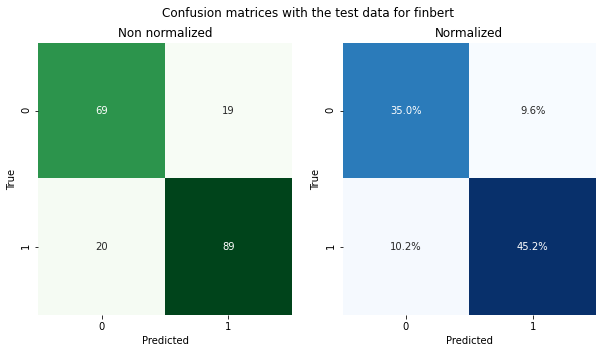

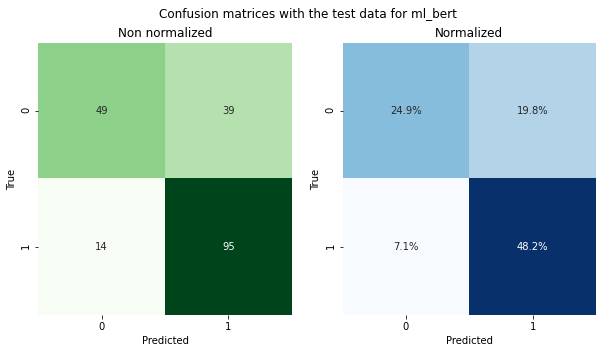

In [38]:
confusion_of_the_highest_orda(fin_matrix,fin_norm,"finbert")
confusion_of_the_highest_orda(matrix_ml,norm_ml,"ml_bert")

The confusion matrices show that the multilingual bert model predicts more false positives than finbert, but in all other ways finbert comes ahead.

In [39]:
def test_dfs(results,d):
  y_pred = np.argmax(results.predictions, axis=1) # array of predicted labels
  y_true = d['test']['label'] 
  test_results_df = pd.DataFrame(data=list(zip(d['test']['text'], y_pred.tolist(), y_true)), 
                            columns=['text', 'prediction', 'true'])

  # successfully predicted entity relations in the test data:
  TP = test_results_df[(test_results_df['true']==1) & (test_results_df['prediction']==1)]
  # successfully predicted NO relations in the test data:
  TN = test_results_df[(test_results_df['true']==0) & (test_results_df['prediction']==0)]
  # False positives: The model thinks there is an entity relation when there truly is not!
  FP = test_results_df[(test_results_df['true']==0) & (test_results_df['prediction']==1)]
  # False negatives: The model thinks there is no entity relation when there truly is!
  FN = test_results_df[(test_results_df['true']==1) & (test_results_df['prediction']==0)]
  return [TP,TN,FP,FN]

In [47]:
def comparison_df(df1,df2):
  """Merge 2 dataframes for comparison"""
  comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
  
  for i in range(len(comparison_df)):
    if comparison_df.loc[i,'_merge'] == 'left_only':
      print("Predicted by finbert only",comparison_df.loc[i,'text'])
    if comparison_df.loc[i,'_merge'] == 'right_only':
      print("Pedicted by multilingual bert only",comparison_df.loc[i,'text'])

In [48]:
count = 0
for df1, df2 in zip(test_dfs(test_results_fin,encoded_dataset_fin),test_dfs(test_results_ml,encoded_dataset)):
  if count == 0:
    print("successfully predicted entity relations",'\n')
    print(comparison_df(df1,df2),'\n')
    count += 1
  if count == 1:
    print("successfully predicted NO relations",'\n')
    print(comparison_df(df1,df2),'\n')
    count += 1
  if count == 2:
    print("False positives",'\n')
    print(comparison_df(df1,df2),'\n')
    count += 1
  if count == 3:
    print("False negatives",'\n')
    print(comparison_df(df1,df2),'\n')
    count += 1

successfully predicted entity relations 

Predicted by finbert only Parisen tuhatta kirjaa 25 liikkeeseen vuodessa lähettävän ORG yrittäjä PERSON kertoo , että Pohjois - Suomessa tehdään kuvakirjoja vähemmän kuin etelässä .
Predicted by finbert only Paikalla Interlagosissa oli myös entinen F1 - kuljettaja Gerhard Berger , yksi PERSON läheisimmistä ystävistä ja monivuotinen tallikaveri ORG - ajoilta 1990 - luvun taitteesta .
Predicted by finbert only ORG suorittamien tutkimusten jälkeen useita salaliittoon sekaantuneita korkea - arvoisia upseereja pidätettiin ja tuomittiin kansantuomioistuimessa vallankaappausyrityksestä ja salaliitosta PERSON vastaan .
Predicted by finbert only Turkkusex - 06 : Sami Hernesaho Pokeritieto : PERSON siirtyy ORG Grand Casino Helsinki : Finnish Poker Awards 2010
Predicted by finbert only Kun ORG jäi muutama vuosi sitten tuumaustauolle , PERSON iski tietynlainen henkinen krapula , vaikka telakalle jääminen tapahtui sulassa yhteisymmärryksessä .
Pedicted by m

##Comparing the two models' metrics on the test data



In [42]:
for i,x in enumerate(zip(ml_metrics.items(),finBert_metrics.items())):
  #print(i,x[0][0],x[1][0])
  if i < 5:
    print(f"Multilingual bert's {x[0][0]} {x[0][1]}","\t",f"Finbert's {x[1][0]} {x[1][1]}")

Multilingual bert's eval_loss 0.6496104001998901 	 Finbert's eval_loss 0.8758606910705566
Multilingual bert's eval_accuracy 0.766497461928934 	 Finbert's eval_accuracy 0.8223350253807107
Multilingual bert's eval_precision 0.7286821705426356 	 Finbert's eval_precision 0.8645833333333334
Multilingual bert's eval_recall 0.8952380952380953 	 Finbert's eval_recall 0.7904761904761904
Multilingual bert's eval_F1-score 0.8034188034188035 	 Finbert's eval_F1-score 0.8258706467661692


The performance metrics with the test data can be accessed with the key "metrics" and the relevant key for each metric.

In [43]:
print("Metrics for the test data with finBert")
print(f"F1-score\t {test_results_fin.metrics['test_F1-score']*100:.3}\nPrecision\t {test_results_fin.metrics['test_precision']*100:.3}\nRecall\t\t {test_results_fin.metrics['test_recall']*100:.3}\nAccuracy\t {test_results_fin.metrics['test_accuracy']*100:.3}")

Metrics for the test data with finBert
F1-score	 82.0
Precision	 82.4
Recall		 81.7
Accuracy	 80.2


In [44]:
print("Metrics for the test data with multilingual bert")
print(f"F1-score\t {test_results_ml.metrics['test_F1-score']*100:.3}\nPrecision\t {test_results_ml.metrics['test_precision']*100:.3}\nRecall\t\t {test_results_ml.metrics['test_recall']*100:.3}\nAccuracy\t {test_results_ml.metrics['test_accuracy']*100:.3}")

Metrics for the test data with multilingual bert
F1-score	 78.2
Precision	 70.9
Recall		 87.2
Accuracy	 73.1


As we see above, the finnish bert edges out in performance on all the metrics except recall. This the result of a single iteration on a fairly small set of data. 

# Milestone 3: A large scale application


- It was somewhat unclear what had to be done in this milestone overall, but we decided that we need to: look through a list of samples that were predicted to have a relation between entities, return the entities (ORG/PER) from the sample and then see which entities appear together most often
- During this milestone we began to notice various problems arising from the data being in Finnish when compared to English. To find the most common entity pairs and to be able to compare and count them, they needed to be normalized  we decided that at least true casing and lemmatization was necessary (before this the mentions also had to be changed back from the ORG/PER forms to their original forms and tokenized). 
- With Finnish having a huge amount of inflected forms, the normalization process was more complicated than it would have been with English (in which one would probably just have to remove structures like possessive and plural forms from nouns). 
- The parser was very slow in Colab, initially running through multiple for-loops, splitting the tokens and putting them back together, and occasionally crashing in the middle  entire process significantly improved once it was ran locally at one point, speed greatly increased  however, finally it didn’t work in the end after all


## Prepare the new data

In [ ]:
!wget -nc -q http://dl.turkunlp.org/TKO_8964_2021/PER-ORG-pairs-fi.tsv

In [ ]:
# some of the charachter encodings do not work in the original data, note the � symbol (rather trivial in big scale?)
%%bash
cat PER-ORG-pairs-fi.tsv | head -15 | less

5ffb399f-8756-3127-9469-15d4c0cf2ff0	unknown	Siitoin tietää myös , että jo kuollut isäni joutui lähtemään juuri tuohon samaan aikaan <ORG>YLE : stä</ORG> , kun <PERSON>Hannu Lemisen</PERSON> johtajakausi päättyi ja isäni savustettiin samaan aikaan ulos TV2 : sta .
4b78d157-5a7e-3167-8ea6-8b623bb4fcc1	unknown	<PERSON>Teemu Selänne</PERSON> syötti kaksi ja Sami Vatanen yhden <ORG>Anaheimin</ORG> maaleista , joista kolme syntyi yli - ja yksi alivoimalla .
3ee089f8-c7fc-37b2-896f-4edd4989ffb0	unknown	<ORG>Ecotools</ORG> lanseerasi uusia siveltimiä ja pääsin niitä ihmettelemään muiden bloggaajien kanssa ihanan ystäväni <PERSON>Heidin</PERSON> hoitolaan , Kauneushoitola Kuiskaukseen .
4050f97f-8b3f-3b84-b189-2526ffae5a6d	unknown	Ei viihdettä eikä urheilua Helsingissä massiivinen vesivahinkoTänään 06 : 32 Pohjois - Korea laukaisi raketinTänään 05 : 08 2 minPäivän sääEilen 22 : 13 TV : Nyt ja seuraavaksi <ORG>Yle</ORG> TV104 : 00 Uutisikkuna08 : 00 Yle UutisetYle TV207 : 49 Hyrräpäät08 : 02 Ni

In [ ]:
ms3=open_file('PER-ORG-pairs-fi.tsv')
print(f"We have {len(ms3)} new documents to analyze.")

We have 100000 new documents to analyze.


In [ ]:
text = [re.sub(pattern_person, "PERSON", item) for item in ms3['document']]
text = [re.sub(pattern_org, "ORG", item) for item in text]

df = pd.DataFrame(text, columns =['text'])
new_dataset = Dataset.from_pandas(df, features=Features( # provide the feature classes to make sure you get what you need
    {'text': Value('string')}
     )
)

new_dataset = DatasetDict({
    'new': new_dataset})

# tokenize the data
encoded_new = new_dataset.map(encode_dataset_finBert)

## Predict with the model

In [ ]:
results = trainer_fin.predict(test_dataset=encoded_new['new'])

In [ ]:
y_pred_fin = np.argmax(results.predictions, axis=1) # array of predicted labels
# join texts and labels
fin_predicted = pd.DataFrame(list(zip(y_pred_fin, ms3['document'])), columns =['predicted label', 'text'])

In [ ]:
fin_predicted.head()

,predicted label,text
0,0,"Siitoin tietää myös , että jo kuollut isäni jo..."
1,0,<PERSON>Teemu Selänne</PERSON> syötti kaksi ja...
2,0,<ORG>Ecotools</ORG> lanseerasi uusia siveltimi...
3,0,Ei viihdettä eikä urheilua Helsingissä massiiv...
4,1,<ORG>Unibet</ORG> Kirjoittaja <PERSON>Pete83</...


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/gdrive/My Drive/Textual_Data_Analysis"


#!mkdir '{predictions_file_path}' # if you haven't created the folder before (note: you only need to do this once!)
predictions_file_path = file_path+"/content/drive/My Drive/Textual_Data_Analysis/predictions/model_predictions.csv"

In [ ]:
# save the predictions
fin_predicted.to_csv("/content/drive/My Drive/Textual_Data_Analysis/model_predictions.csv", index=False)

In [50]:
# or load the predictions

fin_predicted = pd.read_csv("/content/drive/My Drive/Textual_Data_Analysis/model_predictions.csv", sep=',')
fin_predicted

,predicted label,text
0,0,"Siitoin tietää myös , että jo kuollut isäni jo..."
1,1,<PERSON>Teemu Selänne</PERSON> syötti kaksi ja...
2,0,<ORG>Ecotools</ORG> lanseerasi uusia siveltimi...
3,0,Ei viihdettä eikä urheilua Helsingissä massiiv...
4,0,<ORG>Unibet</ORG> Kirjoittaja <PERSON>Pete83</...
...,...,...
99995,1,Latvalan etuautoa ajoi kokenut <ORG>Monte</ORG...
99996,0,Tällä viikolla olisi vielä tarkoitus lopultaki...
99997,0,Olen ihastunut <PERSON>Magnus Silfvenius Öhman...
99998,1,Rikoskomisario <PERSON>Timo Pirinen</PERSON> o...


## Performance evaluation

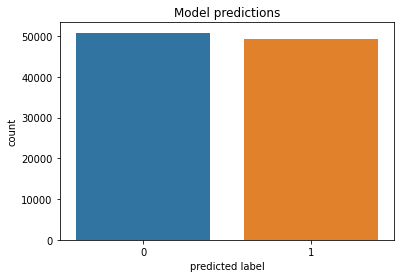

In [51]:
sns.countplot(data=fin_predicted, x='predicted label').set_title('Model predictions');

In [52]:
relations = fin_predicted.loc[fin_predicted['predicted label']==1]

Note here that `re.search` finds the first or only occurence and returns a match object. `re.findall` finds all of the occurences and returns a list. Since we do not feel like handling the match objects, we just unravel the nested list we receive after using `re.findall`.

In [53]:
per = [re.findall(r'<PERSON>(.+)</PERSON>', item) for item in relations['text']]
org = [re.findall(r'<ORG>(.+)</ORG>', item) for item in relations['text']]

per = [item for sublist in per for item in sublist] # flatten a nested list: https://stackoverflow.com/a/952952
org = [item for sublist in org for item in sublist] 

In [54]:
for i in range(5):
  print(i, "person:", per[i], "\n  organization:", org[i])

0 person: Teemu Selänne 
  organization: Anaheimin
1 person: Jarno Pikkaraisen 
  organization: TPS
2 person: Martti Peippo 
  organization: Suomen Koripalloliitto
3 person: Murray Baronin 
  organization: Canucks
4 person: JUTTA 
  organization: Tampereen yliopisto Johtamiskorkeakoulu


##Looking at counts of entities and their frequencies to appear in a relation

In [55]:
org = [re.sub('\s:\s', ':',t) for t in org] # colon issue: TTVO : lla --> TTVO:lla
org = [re.sub('(\s\S)$', '',t) for t in org] # whitespace issue: EAME a --> EAME

In [56]:
#Lowercase the entities to get more duplicates
org = [s.lower() for s in org]
per = [s.lower() for s in per]

In [57]:
def count_duplicates(list):
  """Pick up duplicates and their counts into a dictionairy"""
  duplicates = {}
  for i in list:
    duplicates[i] = list.count(i)
  lista = sorted(duplicates.items(), key=lambda x: x[1], reverse=True)
  return lista

In [58]:
sorted_orgs = count_duplicates(org)
sorted_persons = count_duplicates(per)

In [59]:
entities = list(zip(org,per))

In [60]:
print("20 most common organizations:")
for i in sorted_orgs[:20]:
  print(i[0], i[1])
print()
print("20 most common persons:")
for i in sorted_persons[:20]:
  print(i[0], i[1])

20 most common organizations:
yle 423
nhl 326
kok 252
catholic - hierarchy . org 212
helsingin yliopiston 195
kesk 180
ilveksen 163
tapparan 157
nhl:ssä 155
kokoomuksen 154
sd 144
tps:n 143
sdp:n 139
ässien 135
hifk:n 134
keskustan 133
saipan 126
perussuomalaisten 125
lukon 120
kalpan 118

20 most common persons:
markus jänttiä 55
korhonen 49
juha sipilä 48
alexander stubb 42
timo soini 40
ilmari rostila 40
niemi 38
markus jäntti 37
antti rinne 35
tanja nieminen 35
sture fjäder 34
nieminen 34
jyrki katainen 31
miettinen 28
erkki liikanen 28
edgar paulin 28
virtanen 28
rajeev suri 27
kapanen 27
antti 27


In [61]:
import collections

related_entities = collections.Counter(entities)

In [64]:
print("Most often related entities")
related_entities.most_common(10)

Most often related entities


[(('suomen perusta', 'ilmari rostila'), 40),
 (('helsingin yliopiston', 'markus jäntti'), 36),
 (('tts', 'tanja nieminen'), 33),
 (('kesk', 'juha sipilä'), 29),
 (('helsingin yliopiston', 'markus jänttiä'), 28),
 (('eif', 'edgar paulin'), 28),
 (('akavan', 'sture fjäder'), 27),
 (('palkansaajien tutkimuslaitos', 'markus jänttiä'), 27),
 (('kok', 'alexander stubb'), 26),
 (('suomen pankin', 'erkki liikanen'), 25)]

As we see above the most common entitities that are related to each other consern political parties, institutions and their represantives.

## Lemmatization with the TurkuNLP parser

After spending hours on trying to lemmatize with the TurkuNLP parser we discarded this approach as the parser would not work with the amount of data given and would crash the colab.

https://github.com/TurkuNLP/Turku-neural-parser-pipeline/blob/modularize/turku_neural_parser_colab.ipynb

In [ ]:
# the parser
!wget -q http://dl.turkunlp.org/turku-parser-models/turku_neural_parser-0.3-py3-none-any.whl
!pip3 --quiet install turku_neural_parser-0.3-py3-none-any.whl

# installations (versions) required for the parser to work on colab
!pip --quiet install torch==1.7.0 torchtext==0.4.0 overrides==3.1.0

In [ ]:
#Tällä saadaan parser toimimaan gpu:lla
import types
extra_args=types.SimpleNamespace()
extra_args.__dict__["udify_mod.device"]="0" #simulates someone giving a --device 0 parameter to Udify
extra_args.__dict__["lemmatizer_mod.device"]="0"

# Download and unpack the model
!wget -nc http://dl.turkunlp.org/turku-parser-models/models_fi_tdt_v2.7.tar.gz
!tar zxvf models_fi_tdt_v2.7.tar.gz

#Importataan turku neural parser 
from tnparser.pipeline import read_pipelines, Pipeline
available_pipelines=read_pipelines("models_fi_tdt_v2.7/pipelines.yaml") # insert your model name here (model-name/pipelines.yaml)

#Eri tavat parsettaa teksti
print(list(available_pipelines.keys()))

In [ ]:
p=Pipeline(available_pipelines["parse_plaintext"],extra_args)
print(p.parse("Minulla on ruskea koira! Se haukkuu ja juoksee. Voi että!"))

The format of the data causes problems for the parser:

For example "AC - Sanaforin" is parsed correctly to "AC - Sanafor" but "TTVO : lla" remains  "TTVO : lla" apparently because of the " : ". This needs to be replaced with ":" before the parsing!

Also "EAME a" is "EAME a" even after the parsing. How to fix it?

In [ ]:
def parse(list):
  lista = [p.parse(i) for i in list]
  token_list = []
  for i in lista:
    pars = conllu.parse(i)
    for j in pars:
      
      lemmat = []
      for x in j:
        
        lemmat.append(("".join(x['lemma'])))
      tokens_of_one_entity=' '.join(lemmat)
      token_list.append(tokens_of_one_entity)  
  return token_list

In [ ]:
print(len(per))
print(len(org))

In [ ]:
import time 

t0 = time.time()
per_lemmas = [parse(i) for i in per]
org_lemmas = [[parse(i) for i in org]]

t1 = time.time()

print(f"To parse {len(per)+len(org)} entities {(t1-t0)/60:.3} minutes elapsed")

In [ ]:
len(per_lemmas)

In [ ]:
!mkdir /content/drive/MyDrive/Textual_Data_Analysis/lemmattisoidut

In [ ]:
df = pd.DataFrame(list(zip(per_lemmas,org_lemmas)),columns=['per_lemma','org_lemma'])

In [ ]:
df.to_csv("drive/MyDrive/Textual_Data_Analysis/lemmattisoidut/lemmat.csv")

#end